In [1]:
from typing import TypeVar

import torch.nn as nn
import torch.optim as optim
from gymnasium import spaces
import numpy as np
import torch
import gym
from copy import deepcopy
from torch.distributions.categorical import Categorical
from tqdm.auto import tqdm

from lasertag import Lasertag, LasertagCorridor1

import matplotlib.pyplot as plt
from syllabus.core import (
    Curriculum,
    TaskWrapper,
    PettingZooMultiProcessingSyncWrapper,
    make_multiprocessing_curriculum,
)
from syllabus.task_space import TaskSpace
from syllabus.curricula import DomainRandomization

ObsType = TypeVar("ObsType")
ActionType = TypeVar("ActionType")
AgentID = TypeVar("AgentID")

c:\Users\ryanp\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-26 09:50:06,000	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


# ***Env wrapper***

In [2]:
class LasertagParallelWrapper(TaskWrapper):
    """
    Wrapper ensuring compatibility with the PettingZoo Parallel API.

    Lasertag Environment:
        * Action shape:  `n_agents` * `Discrete(5)`
        * Observation shape: Dict('image': Box(0, 255, (`n_agents`, 3, 5, 5), uint8))
    """

    def __init__(self, n_agents, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_agents = n_agents
        self.task = None
        self.episode_return = 0
        self.task_space = TaskSpace(spaces.MultiDiscrete(np.array([[2], [5]])))
        self.possible_agents = np.arange(self.n_agents)

    def _np_array_to_pz_dict(self, array: np.ndarray) -> dict[str : np.ndarray]:
        """
        Returns a dictionary containing individual observations for each agent.
        Assumes that the batch dimension represents individual agents.
        """
        out = {}
        for idx, i in enumerate(array):
            out[str(idx)] = i
        return out

    def _singleton_to_pz_dict(self, value: bool) -> dict[str:bool]:
        """
        Broadcasts the `done` and `trunc` flags to dictionaries keyed by agent id.
        """
        return {str(idx): value for idx in range(self.n_agents)}

    def reset(self) -> tuple[dict[AgentID, ObsType], dict[AgentID, dict]]:
        """
        Resets the environment and returns a dictionary of observations
        keyed by agent ID.
        """
        obs = self.env.reset()
        pz_obs = self._np_array_to_pz_dict(obs["image"])

        return pz_obs

    def step(self, action: dict[AgentID, ActionType]) -> tuple[
        dict[AgentID, ObsType],
        dict[AgentID, float],
        dict[AgentID, bool],
        dict[AgentID, bool],
        dict[AgentID, dict],
    ]:
        """
        Takes inputs in the PettingZoo (PZ) Parallel API format, performs a step and
        returns outputs in PZ format.
        """
        obs, rew, done, info = self.env.step(action)
        obs = obs['image']
        trunc = 0  # there is no `truncated` flag in this environment
        self.task_completion = self._task_completion(obs, rew, done, trunc, info)
        # convert outputs back to PZ format
        obs, rew = tuple(map(self._np_array_to_pz_dict, [obs, rew]))
        done, trunc, info = tuple(
            map(self._singleton_to_pz_dict, [done, trunc, self.task_completion])
        )

        return self.observation(obs), rew, done, trunc, info

# ***Self-Play***

In [3]:
class SelfPlay(Curriculum):
    def __init__(self, agent):
        self.agent = deepcopy(agent)

    def update_agent(self, agent):
        self.agent = deepcopy(agent)

    def get_opponent(self):
        # Always return the most recent agent
        return self.agent

    def sample(self, k=1):
        return 0

# ***PPO***

In [4]:
class Agent(nn.Module):
    def __init__(self, num_actions):
        super().__init__()

        self.network = nn.Sequential(
            self._layer_init(nn.Linear(3 * 5 * 5, 512)),
            nn.ReLU(),
        )
        self.actor = self._layer_init(nn.Linear(512, num_actions), std=0.01)
        self.critic = self._layer_init(nn.Linear(512, 1))

    def _layer_init(self, layer, std=np.sqrt(2), bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)
        return layer

    def get_value(self, x, flatten_start_dim=1):
        x = torch.flatten(x, start_dim=flatten_start_dim)
        return self.critic(self.network(x / 255.0))

    def get_action_and_value(self, x, action=None, flatten_start_dim=1):
        x = torch.flatten(x, start_dim=flatten_start_dim)
        hidden = self.network(x / 255.0)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

In [5]:
def batchify_obs(obs, device):
    """Converts PZ style observations to batch of torch arrays."""
    # convert to list of np arrays
    obs = np.stack([obs[a] for a in obs], axis=0)
    # convert to torch
    obs = torch.tensor(obs).to(device)

    return obs


def batchify(x, device):
    """Converts PZ style returns to batch of torch arrays."""
    # convert to list of np arrays
    x = np.stack([x[a] for a in x], axis=0)
    # convert to torch
    x = torch.tensor(x).to(device)

    return x


def unbatchify(x, env):
    """Converts np array to PZ style arguments."""
    x = x.cpu().numpy()
    x = {a: x[i] for i, a in enumerate(env.possible_agents)}

    return x

In [6]:
"""ALGO PARAMS"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ent_coef = 0.1
vf_coef = 0.1
clip_coef = 0.1
gamma = 0.99
batch_size = 32
stack_size = 3
frame_size = (5, 5)
max_cycles = 201 # lasertag has 200 maximum steps by default
total_episodes = 10
n_agents = 2
num_actions = 5

""" LEARNER SETUP """
agent = Agent(num_actions=num_actions).to(device)
optimizer = optim.Adam(agent.parameters(), lr=0.001, eps=1e-5)

""" ENV SETUP """
env = LasertagCorridor1(record_video=True, video_filename="./recordings") # 2 agents by default
env = LasertagParallelWrapper(env=env, n_agents=n_agents)
curriculum = SelfPlay(agent=agent)
observation_size = env.observation_space["image"].shape[1:]

""" ALGO LOGIC: EPISODE STORAGE"""
end_step = 0
total_episodic_return = 0
rb_obs = torch.zeros((max_cycles, n_agents, stack_size, *frame_size)).to(device)
rb_actions = torch.zeros((max_cycles, n_agents)).to(device)
rb_logprobs = torch.zeros((max_cycles, n_agents)).to(device)
rb_rewards = torch.zeros((max_cycles, n_agents)).to(device)
rb_terms = torch.zeros((max_cycles, n_agents)).to(device)
rb_values = torch.zeros((max_cycles, n_agents)).to(device)

losses, episode_rewards = [], []

In [7]:
""" TRAINING LOGIC """
# train for n number of episodes
for episode in tqdm(range(total_episodes)):
    # collect an episode
    with torch.no_grad():
        # collect observations and convert to batch of torch tensors
        next_obs = env.reset()  # removed seed=None and info
        # reset the episodic return
        total_episodic_return = 0

        # each episode has num_steps
        for step in range(0, max_cycles):
            # rollover the observation
            joint_obs = batchify_obs(next_obs, device)
            agent_obs, opponent_obs = joint_obs

            # get action from the agent and the opponent
            actions, logprobs, _, values = agent.get_action_and_value(
                agent_obs, flatten_start_dim=0
            )
            opponent = curriculum.get_opponent()
            opponent_action, *_ = opponent.get_action_and_value(
                opponent_obs, flatten_start_dim=0
            )
            # execute the environment and log data
            joint_actions = torch.tensor((actions, opponent_action))
            next_obs, rewards, terms, truncs, infos = env.step(
                unbatchify(joint_actions, env)
            )
            episode_rewards.append(max(list(rewards.values())))

            # add to episode storage
            rb_obs[step] = joint_obs
            rb_rewards[step] = batchify(rewards, device)
            rb_terms[step] = batchify(terms, device)
            rb_actions[step] = actions
            rb_logprobs[step] = logprobs
            rb_values[step] = values.flatten()

            # compute episodic return
            total_episodic_return += rb_rewards[step].cpu().numpy()

            # if we reach termination or truncation, end
            if any([terms[a] for a in terms]) or any([truncs[a] for a in truncs]):
                end_step = step
                break

    # bootstrap value if not done
    with torch.no_grad():
        rb_advantages = torch.zeros_like(rb_rewards).to(device)
        for t in reversed(range(end_step)):
            delta = (
                rb_rewards[t]
                + gamma * rb_values[t + 1] * rb_terms[t + 1]
                - rb_values[t]
            )
            rb_advantages[t] = delta + gamma * gamma * rb_advantages[t + 1]
        rb_returns = rb_advantages + rb_values
    # convert our episodes to batch of individual transitions
    b_obs = torch.flatten(rb_obs[:end_step], start_dim=0, end_dim=1)
    b_logprobs = torch.flatten(rb_logprobs[:end_step], start_dim=0, end_dim=1)
    b_actions = torch.flatten(rb_actions[:end_step], start_dim=0, end_dim=1)
    b_returns = torch.flatten(rb_returns[:end_step], start_dim=0, end_dim=1)
    b_values = torch.flatten(rb_values[:end_step], start_dim=0, end_dim=1)
    b_advantages = torch.flatten(rb_advantages[:end_step], start_dim=0, end_dim=1)

    # Optimizing the policy and value network
    b_index = np.arange(len(b_obs))
    clip_fracs = []
    for repeat in range(3):
        # shuffle the indices we use to access the data
        np.random.shuffle(b_index)
        for start in range(0, len(b_obs), batch_size):
            # select the indices we want to train on
            end = start + batch_size
            batch_index = b_index[start:end]

            _, newlogprob, entropy, value = agent.get_action_and_value(
                b_obs[batch_index], b_actions.long()[batch_index]
            )
            logratio = newlogprob - b_logprobs[batch_index]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clip_fracs += [((ratio - 1.0).abs() > clip_coef).float().mean().item()]

            # normalize advantages
            advantages = b_advantages[batch_index]
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -b_advantages[batch_index] * ratio
            pg_loss2 = -b_advantages[batch_index] * torch.clamp(
                ratio, 1 - clip_coef, 1 + clip_coef
            )
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            value = value.flatten()
            v_loss_unclipped = (value - b_returns[batch_index]) ** 2
            v_clipped = b_values[batch_index] + torch.clamp(
                value - b_values[batch_index],
                -clip_coef,
                clip_coef,
            )
            v_loss_clipped = (v_clipped - b_returns[batch_index]) ** 2
            v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
            v_loss = 0.5 * v_loss_max.mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * vf_coef
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # update opponent
    curriculum.update_agent(agent)

print(f"Training episode {episode}")
print(f"Episodic Return: {np.mean(total_episodic_return)}")
print(f"Episode Length: {end_step}")
print("")
print(f"Value Loss: {v_loss.item()}")
print(f"Policy Loss: {pg_loss.item()}")
print(f"Old Approx KL: {old_approx_kl.item()}")
print(f"Approx KL: {approx_kl.item()}")
print(f"Clip Fraction: {np.mean(clip_fracs)}")
print(f"Explained Variance: {explained_var.item()}")
print("\n-------------------------------------------\n")

  0%|          | 0/10 [00:02<?, ?it/s]


PermissionError: [Errno 13] Permission denied: 'C:/Users/ryanp/OneDrive/Documents/Syllabus-1/lasertag_recordings'

In [ ]:
import plotly.express as px

In [ ]:
px.bar(np.bincount(rb_actions.numpy().reshape(-1).astype(np.int64)))

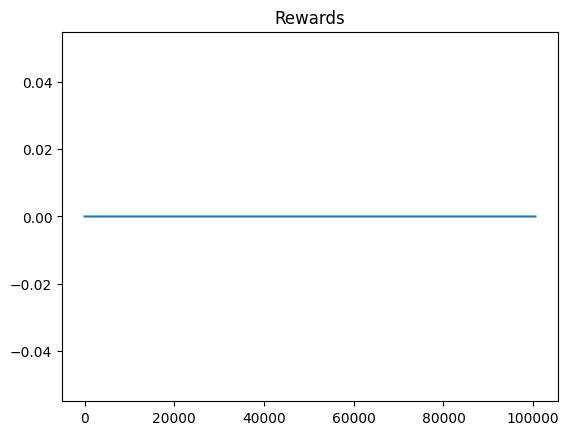

In [ ]:
plt.plot(episode_rewards)
plt.title("Rewards")
plt.show()

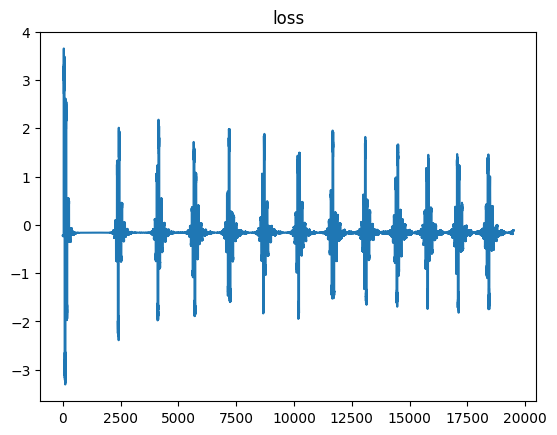

In [ ]:
plt.plot(list(map(lambda x: x.detach().numpy(), losses)))
plt.title("loss")
plt.show()